In [15]:
import pandas as pd
import networkx as nx
from itertools import combinations
import matplotlib.pyplot as plt

Data Preview:
                                      thread_subject   username  \
0   English descriptions for Latvian municipalities        Sk!d   
1   English descriptions for Latvian municipalities   Ymblanter   
2   English descriptions for Latvian municipalities     Legoktm   
3               Fix calling of [[Template:archive]]     Kaganer   
4               Fix calling of [[Template:archive]]     Bináris   

                               page_name  
0  WikidataBotrequestsArchive201302.json  
1  WikidataBotrequestsArchive201302.json  
2  WikidataBotrequestsArchive201302.json  
3  WikidataBotrequestsArchive201302.json  
4  WikidataBotrequestsArchive201302.json  

Network Summary:
Number of Nodes (Editors): 552
Number of Edges (Social Connections): 2425

Filtered Network Summary:
Number of Nodes (Editors): 146
Number of Edges (Social Connections): 453


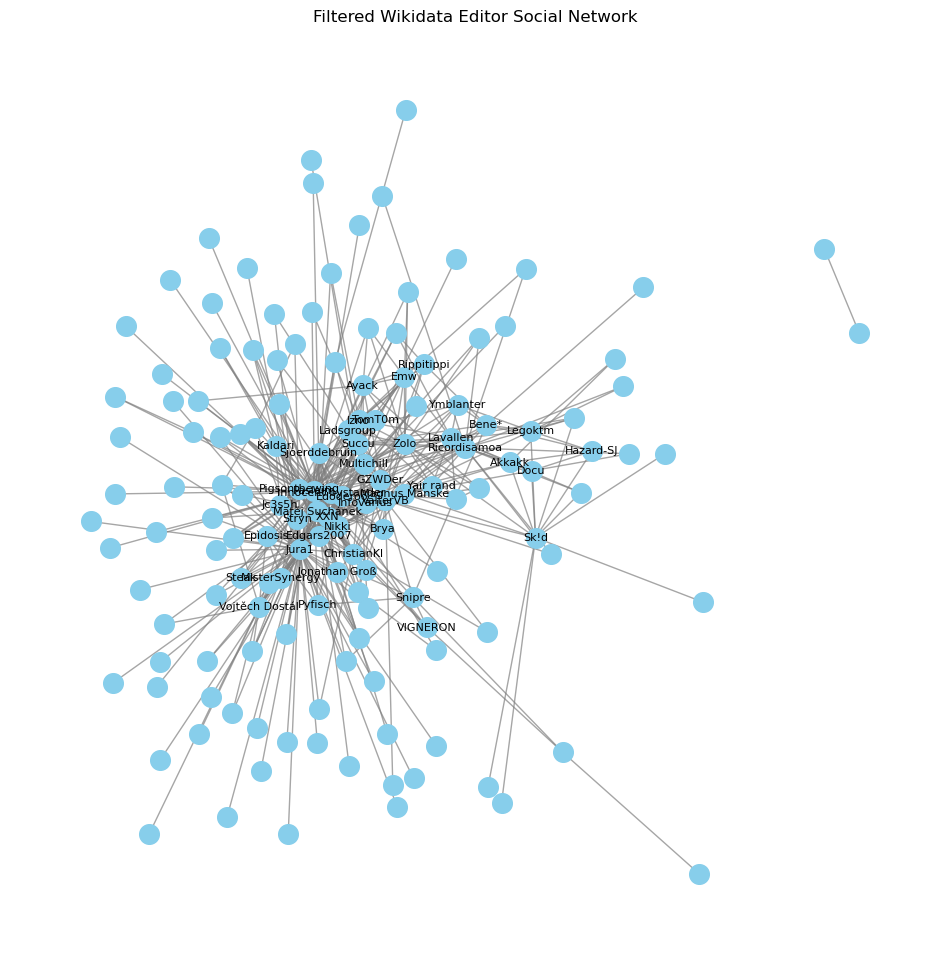

In [17]:


# 1. Load Data
df = pd.read_csv('BOT_REQUESTS.csv')
print("Data Preview:")
print(df.head())

# 2. Initialize the Graph
G = nx.Graph()
unique_users = df['username'].unique()
for user in unique_users:
    G.add_node(user)

# 3. Construct Edges
grouped = df.groupby(['page_name', 'thread_subject'])
for (page, thread), group in grouped:
    users_in_group = group['username'].unique()
    for user1, user2 in combinations(users_in_group, 2):
        if G.has_edge(user1, user2):
            G[user1][user2]['weight'] += 1
            G[user1][user2]['contexts'].append((page, thread))
        else:
            G.add_edge(user1, user2, weight=1, contexts=[(page, thread)])

# 输出网络摘要信息
print("\nNetwork Summary:")
print("Number of Nodes (Editors):", G.number_of_nodes())
print("Number of Edges (Social Connections):", G.number_of_edges())

# 4. Filtering & Visualization
# --------------------------------------------------------------------
#   (A) 节点过滤：仅保留度数 >= degree_threshold 的节点
#   (B) 边过滤：仅保留权重 >= weight_threshold 的边
#   (C) 调整布局参数和画布大小
# --------------------------------------------------------------------

# (A) 过滤度数较低的节点
degree_threshold = 5
high_degree_nodes = [n for n, deg in G.degree() if deg >= degree_threshold]
subG = G.subgraph(high_degree_nodes).copy()

# (B) 进一步过滤权重较低的边（可选）
weight_threshold = 2
edges_to_keep = [(u, v) for (u, v, d) in subG.edges(data=True) 
                 if d['weight'] >= weight_threshold]
subG = subG.edge_subgraph(edges_to_keep).copy()

# 如果过滤后节点数量非常少或为 0，需要根据实际情况降低阈值
print("\nFiltered Network Summary:")
print("Number of Nodes (Editors):", subG.number_of_nodes())
print("Number of Edges (Social Connections):", subG.number_of_edges())

# 画布大小和布局设置
plt.figure(figsize=(12, 12))
# 调整 k 值和 iterations 次数可以让节点分布得更松散或更紧凑
pos = nx.spring_layout(subG, k=0.3, iterations=50, seed=42)

# 绘制节点
nx.draw_networkx_nodes(subG, pos, node_size=200, node_color='skyblue')

# 绘制边
nx.draw_networkx_edges(subG, pos, width=1, alpha=0.7, edge_color='gray')

# 仅为度数较高的节点添加标签（避免标签过于密集）
labels_to_show = {n: n for n, deg in subG.degree() if deg >= degree_threshold}
nx.draw_networkx_labels(subG, pos, labels=labels_to_show, font_size=8)

plt.title("Filtered Wikidata Editor Social Network")
plt.axis('off')
plt.show()
